# Ground-roll attenuation model with attention

Raw field seismograms contain noises of various nature. One type of noise is assosiated with ground-roll waves propagation. The model should suppress the ground-roll noise and keep desired signal unchanged.

* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Runnig time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

## Dataset

We exploit the Dataset 1 from a list of dataset on ground-roll attenuation. Description of the Dataset 1 is available [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/noise_attenuation.ipynb). 10 first seismograms of the train part we keep for model training, the rest ones for testing. 

Required imports:

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

sys.path.append('../../..')

from seismicpro.batchflow import Pipeline, V, B, L, I, W
from seismicpro.batchflow.models.tf.layers import conv_block
from seismicpro.batchflow.models.tf import UNet

from seismicpro.src import (SeismicDataset, FieldIndex, TraceIndex, statistics_plot,
                            seismic_plot, spectrum_plot, merge_segy_files)
from seismicpro.models import UnetAttGauss1, attention_loss_gauss, FieldMetrics

%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


Index dataset

In [2]:
path_raw = '/notebooks/data/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/data/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
index.head()

,TraceNumber,offset,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
111906,1656,35,1,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,1,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,1657,36,2,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,2,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,1655,78,3,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,3,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,1658,79,4,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,4,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,1654,127,5,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,5,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...


Reserve 10 field records for model training:

In [3]:
tindex = TraceIndex(index.create_subset(index.indices[:10]))
train_set = SeismicDataset(tindex)

## Model architecture

Model consists of 2 U-Net branches, the first one is for signal filtering, the second one is for attention mask.

Define the model config and loss function:

In [4]:
model_config = {
    'initial_block/inputs': 'trace_raw',
    'inputs': dict(trace_raw={'shape': (3000, 1)},
#                    offset={'shape': (1, )},
                   lift={'name': 'targets', 'shape': (3000, 1)}),

    'loss': (attention_loss_gauss, {'balance': 0.05}),
    'optimizer': ('Adam', {'learning_rate': 0.0001}),
#     'decay': {'name': 'cyclic', 'learning_rate':0.0001, 'max_lr': 0.003, 'step_size': 20},
#     'decay': {'name': 'invtime', 'learning_rate':0.001, 'decay_steps': 100, 'decay_rate': 0.05},
    'common/data_format': 'channels_last',
    'body': {
        'main': {
            'encoder/num_stages': 5,
            'encoder/blocks': dict(layout='ca ca',
                                   filters=[16, 32, 64, 128, 256],
                                   kernel_size=[7, 5, 5, 5, 5],
                                   activation=tf.nn.elu),
            'encoder/downsample': dict(layout='pd',
                                       pool_size=2,
                                       pool_strides=2,
                                       dropout_rate=0.05),

            'decoder/blocks': dict(layout='ca ca',
                                   filters=[16, 32, 64, 128, 256][::-1],
                                   kernel_size=[7, 5, 5, 5, 5][::-1],
                                   activation=tf.nn.elu),
            'decoder/upsample': dict(layout='tad',
                                     kernel_size=[7, 5, 5, 5, 5][::-1],
                                     strides=2,
                                     dropout_rate=0.05,
                                     activation=tf.nn.elu,),
          },
        'attn': {
              'encoder/num_stages': 5,
              'encoder/blocks': dict(layout='ca ca',
                                     filters=[8, 16, 32, 64, 128],
                                     kernel_size=3,
                                     activation=tf.nn.elu),
              'encoder/downsample': dict(layout='pd',
                                         pool_size=2,
                                         pool_strides=2,
                                         dropout_rate=0.05),

              'decoder/blocks': dict(layout='ca ca',
                                     filters=[8, 16, 32, 64, 128][::-1],
                                     kernel_size=3,
                                     activation=tf.nn.elu),
              'decoder/upsample': dict(layout='ta d',
                                       kernel_size=3,
                                       strides=2,
                                       dropout_rate=0.05,
                                       activation=tf.nn.elu),
        },
    },
    'head': {'scale': 2 * np.sqrt(np.log(2))}, #{'layout': 'fafafa', 'units':[16, 16, 1], 'activation':tf.nn.elu},
    'train_steps': {
#         'sss': {},
                
        'step_main': {'scope': 'main_branch'},
        'step_attention': {'scope': ['attention_branch', 'attention_dense']},

    }
}

## Training

Training pipeline actions:
* loading a batch of raw and target traces
* model weights update

Optimizer configuration:
* optimizer: Adam
* learning_rate = 0.0001

Loss balance: 0.05

Training scheme:
* ```batch_size``` = 64
* ```n_epochs``` = 2.

Define a train pipeline:

In [5]:
def exp_stack(x):
    return np.expand_dims(np.vstack(x), -1)

def make_data(batch, **kwagrs):
    return {'trace_raw': exp_stack(batch.raw),
#                           'offset': np.vstack(batch.trace_headers('offset')),
                          'lift': exp_stack(batch.lift)}

train_pipeline = (Pipeline()
                  .init_model('dynamic', UnetAttGauss1, name='unet', config=model_config)
                  .init_variable('loss', default=list())
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .train_model('unet', make_data=make_data, fetches='loss_step_main', save_to=V('loss', 'a'))
                 )

Specify a dataset for model training:

In [6]:
train_pipeline = train_pipeline << train_set

Run model training for 3 epochs with batch size of 64:

In [7]:
batch_size = 64

train_pipeline = train_pipeline.run(batch_size=batch_size, n_epochs=2, drop_last=True,
                                    shuffle=True, bar=True, bar_desc=W(V('loss')[-1].format('Current loss is: {:7.7}')))

Current loss is: 0.02338278: 100%|██████████| 1080/1080 [05:17<00:00,  3.38it/s]


Plot loss function decay:

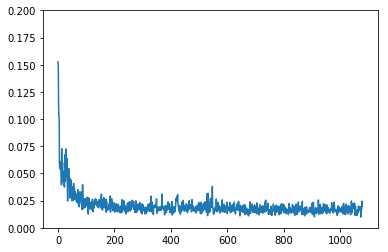

In [8]:
loss = np.array(train_pipeline.get_variable('loss'))
plt.plot(loss)
plt.ylim(0, 0.2)
plt.show()

In [9]:
from scipy import stats
stats.describe(loss[-100:])

DescribeResult(nobs=100, minmax=(0.009869787, 0.024701636), mean=0.016797591, variance=9.3932185e-06, skewness=0.28379109501838684, kurtosis=-0.23420311209361921)

In [10]:
fetches=['out_lift', 'attention_gaussian', 'out_att'] #, 'sigmoid_center']

test_pipeline = (Pipeline()
                 .import_model('unet', train_pipeline)
                 .init_variable('res', default=list())
                 .init_variable('raw', default=list())
                 .init_variable('lift', default=list())
                 .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                 .update_variable('raw', B('raw'), mode='a')
                 .update_variable('lift', B('lift'), mode='a')
                 .predict_model('unet', make_data=make_data, fetches=fetches, save_to=V('res', 'a')))


def check_res(i, test_pipeline, cv=0.1):  
    test_set = SeismicDataset(TraceIndex(index.create_subset(index.indices[i: i+1])))
    test_pipeline = test_pipeline << test_set
    test_pipeline = test_pipeline.run(batch_size=1000, n_epochs=1, drop_last=False,
                                  shuffle=False, bar=True)
    raw = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('raw')])
    lift = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('lift')])
    out = np.squeeze(np.vstack([x[0] for x in test_pipeline.get_variable('res')]))
    att = np.squeeze(np.vstack([x[1] for x in test_pipeline.get_variable('res')]))
    att_raw = np.squeeze(np.vstack([x[2] for x in test_pipeline.get_variable('res')]))
#     sigm_center = np.vstack([x[2] for x in test_pipeline.get_variable('res')])
    seismic_plot([raw, att_raw, att, out, out - raw, out -lift],
             figsize=(19, 7), names=['RAW', 'Noise Raw', 'NOISE MASK', 'OUTPUT', 'OUTPUT - RAW', 'out-lift'],
             cmap='gray', vmin=-cv, vmax=cv)
    
    return raw, att, att_raw, lift, out

Run test pipeline:

100%|██████████| 4/4 [00:08<00:00,  2.28s/it]


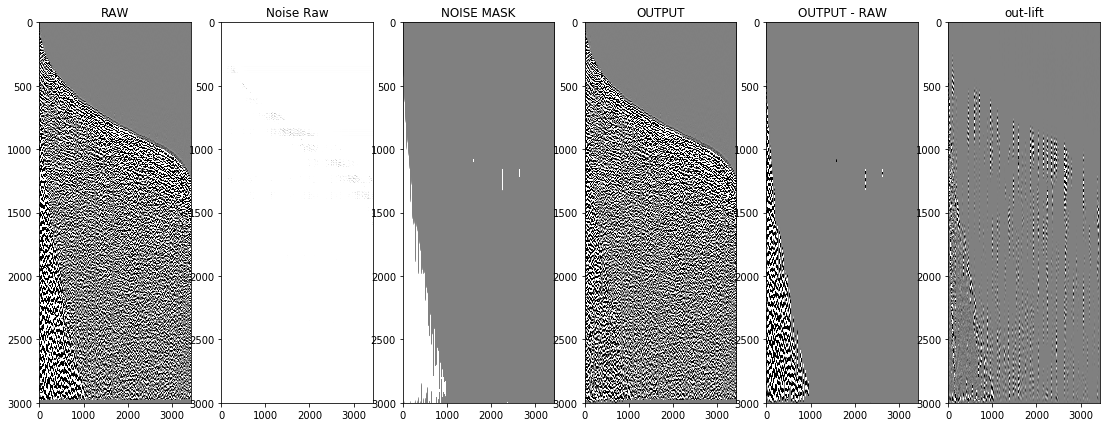

In [11]:
i = 20
raw, att, att_raw, lift, out = check_res(i, test_pipeline)

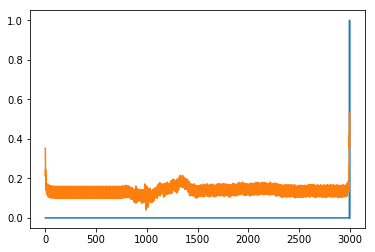

In [12]:
plt.plot(np.vstack([att[2000], att_raw[2000]]).T);

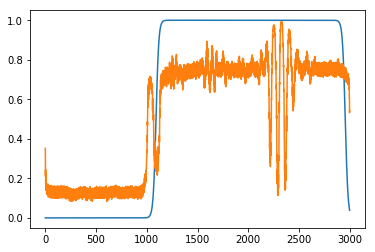

In [13]:
plt.plot(np.vstack([att[100], att_raw[100]]).T);

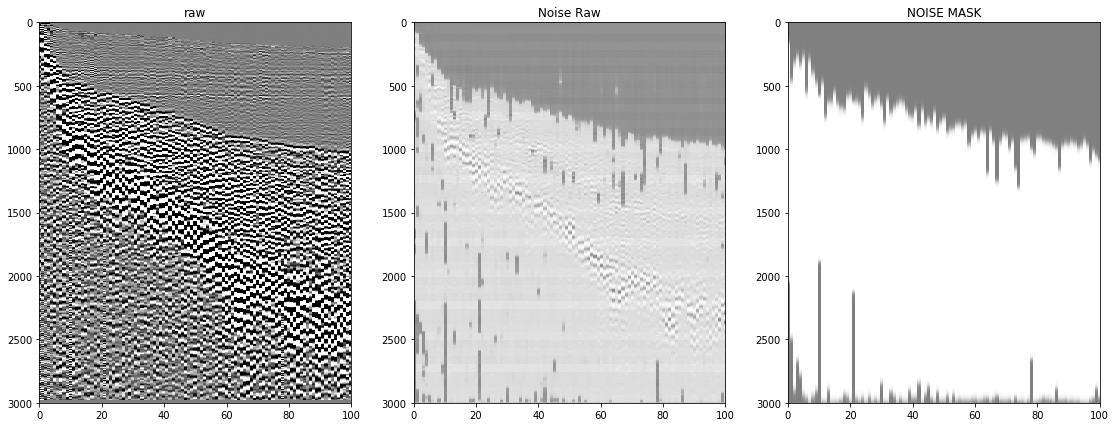

In [14]:
seismic_plot([raw, att_raw, att], xlim=(0, 100),
             figsize=(19, 7), names=['raw','Noise Raw', 'NOISE MASK'],
             cmap='gray', vmin=-1, vmax=1)

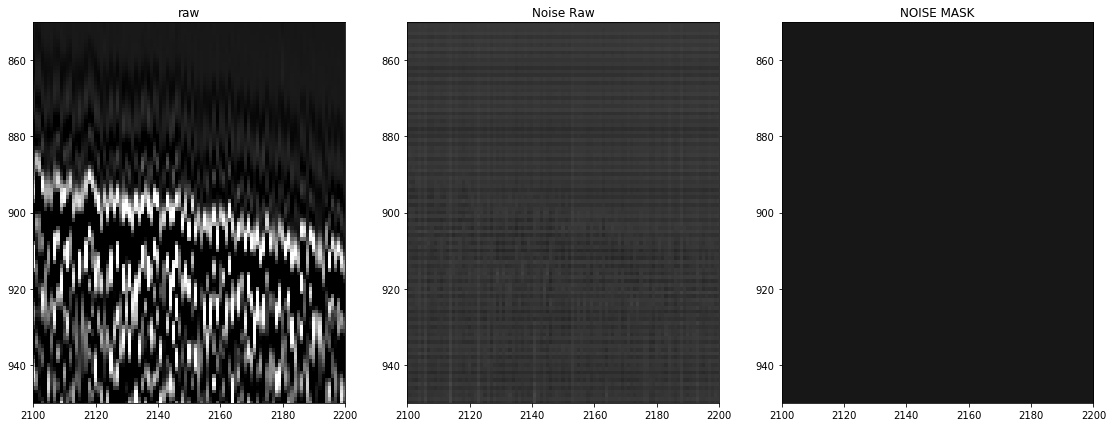

In [15]:
seismic_plot([raw, att_raw, att], xlim=(2100, 2200), ylim=(850, 950),
             figsize=(19, 7), names=['raw','Noise Raw', 'NOISE MASK'],
             cmap='gray', vmin=-0.1, vmax=1)

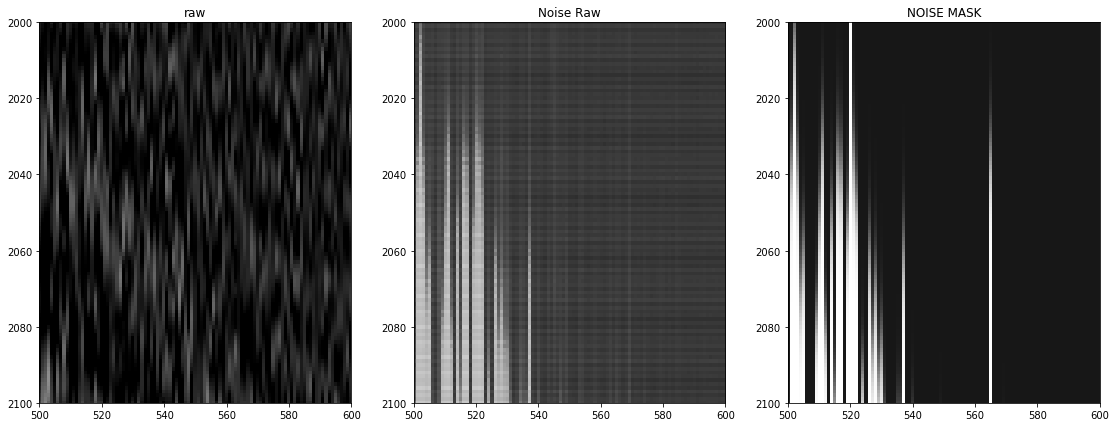

In [16]:
seismic_plot([raw, att_raw, att], xlim=(500, 600), ylim=(2000, 2100),
             figsize=(19, 7), names=['raw','Noise Raw', 'NOISE MASK'],
             cmap='gray', vmin=-0.1, vmax=1)

In [17]:
model_config

{'body': {'attn': {'decoder/blocks': {'activation': <function tensorflow.python.ops.gen_nn_ops.elu(features, name=None)>,
    'filters': [128, 64, 32, 16, 8],
    'kernel_size': 3,
    'layout': 'ca ca'},
   'decoder/upsample': {'activation': <function tensorflow.python.ops.gen_nn_ops.elu(features, name=None)>,
    'dropout_rate': 0.05,
    'kernel_size': 3,
    'layout': 'ta d',
    'strides': 2},
   'encoder/blocks': {'activation': <function tensorflow.python.ops.gen_nn_ops.elu(features, name=None)>,
    'filters': [8, 16, 32, 64, 128],
    'kernel_size': 3,
    'layout': 'ca ca'},
   'encoder/downsample': {'dropout_rate': 0.05,
    'layout': 'pd',
    'pool_size': 2,
    'pool_strides': 2},
   'encoder/num_stages': 5},
  'main': {'decoder/blocks': {'activation': <function tensorflow.python.ops.gen_nn_ops.elu(features, name=None)>,
    'filters': [256, 128, 64, 32, 16],
    'kernel_size': [5, 5, 5, 5, 7],
    'layout': 'ca ca'},
   'decoder/upsample': {'activation': <function tensorf

100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


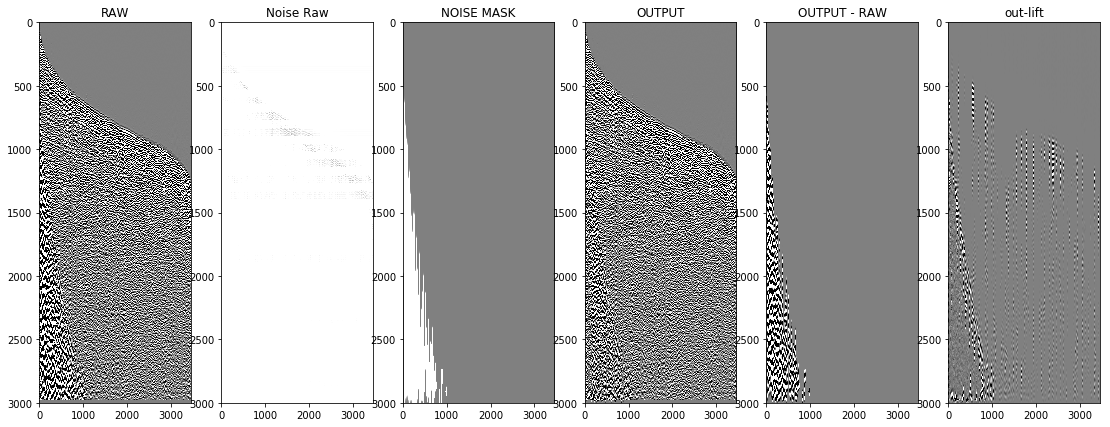

In [18]:
i = 21
check_res(i, test_pipeline);